In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import random
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

# 1. Import and clean the data

In [95]:
df = pd.read_csv('../data/interim/salary_skill_cleaned.csv')
df.head()

,Unnamed: 0,occupation_onet,skill,importance,location,state,annual
0,0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


In [96]:
# Drop 'Unnamed: 0' and rename occupation_onet and annual to occupation and salary
df.drop(columns='Unnamed: 0', axis=1, inplace=True)
df.rename(columns={'occupation_onet':'occupation', 'annual':'salary'}, inplace=True)
df.head()

,occupation,skill,importance,location,state,salary
0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


# 2. Explore the data

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4774000 entries, 0 to 4773999
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   occupation  object 
 1   skill       object 
 2   importance  float64
 3   location    object 
 4   state       object 
 5   salary      float64
dtypes: float64(2), object(4)
memory usage: 218.5+ MB


There are 4,774,000 rows and 6 columns. Importance is the numerical measure of each skill. Only importance and salary are numeric values. 

## 2.1 Categorical features

In [103]:
# Number of unique occupations
occupations = df['occupation'].unique()
df['occupation'].nunique()

788

In [125]:
print(occupations)

['Chief Executives' 'Chief Sustainability Officers'
 'General and Operations Managers' 'Advertising and Promotions Managers'
 'Marketing Managers' 'Sales Managers'
 'Computer and Information Systems Managers' 'Financial Managers'
 'Treasurers and Controllers' 'Investment Fund Managers'
 'Industrial Production Managers' 'Quality Control Systems Managers'
 'Geothermal Production Managers' 'Biofuels Production Managers'
 'Biomass Power Plant Managers' 'Hydroelectric Production Managers'
 'Purchasing Managers'
 'Transportation, Storage, and Distribution Managers'
 'Supply Chain Managers' 'Compensation and Benefits Managers'
 'Human Resources Managers' 'Training and Development Managers'
 'Farmers, Ranchers, and Other Agricultural Managers'
 'Construction Managers'
 'Education and Childcare Administrators, Preschool and Daycare'
 'Education Administrators, Kindergarten through Secondary'
 'Education Administrators, Postsecondary'
 'Architectural and Engineering Managers'
 'Biofuels/Biodiese

In [ ]:
# List of all unique skills
df['skill'].unique()

In [109]:
# Number of unique skills
df['skill'].nunique()

35

In [11]:
# Number of unique locations
locations = df['location'].unique()
df['location'].nunique()

379

There are 35 unique skills, 379 unique locations and 788 unique occupations

## 2.2 Numerical features

### 2.2.1 Target feature (salary)

In [115]:
# Annual mean salary across all occupations
all_mean = np.mean(df['salary'])
all_std = np.std(df['salary'])
all_median = np.median(df['salary'])
print('Mean of all salaries: ' + str(round(all_mean, 2)))
print('Standard deviation: ' + str(round(all_std, 2)))

Mean of all salaries: 61028.51
Standard deviation: 32704.42


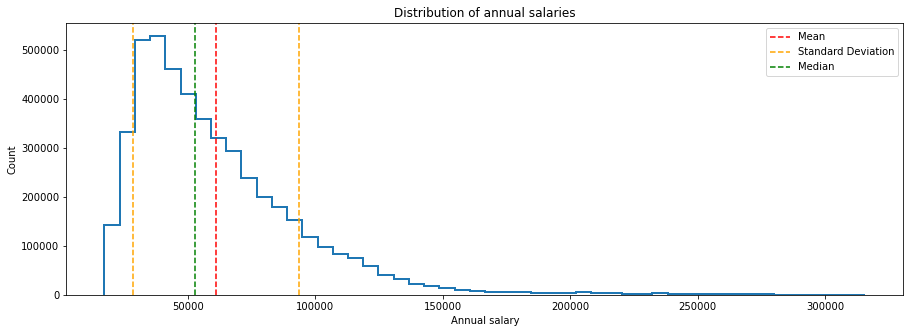

In [124]:
# Annual salary distribution for all occupations, with mean and one standard deviation represented with red and orange lines
# and the median in green
ax, fig = plt.subplots(figsize=(15, 5))
plt.hist(df['salary'], bins=50, histtype='step', linewidth = 2)
plt.axvline(x=all_mean, linestyle='--', color='red', label='Mean')
plt.axvline(x=all_mean - all_std, linestyle='--', color='orange', label='Standard Deviation')
plt.axvline(x=all_mean + all_std, linestyle='--', color='orange')
plt.axvline(x=all_median, linestyle='--', color='green', label='Median')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of annual salaries')
plt.legend()
plt;

The annual salary distribution is highly skewed to the right, indicating very few earners above $150,000.

#### 2.2.1 Salary distributions for a few occuptions

In [143]:
# Funtion that plots the salary distribution for a given occupation
def salary_dist(job):
    new_slice = df[['occupation', 'location', 'salary']]
    new_slice = new_slice[~new_slice.duplicated()]
    new_slice[new_slice['occupation']==job].salary.hist()
    plt.xlabel('Salary')
    plt.ylabel('Count')
    plt.title('Distribution of salary for ' + job);

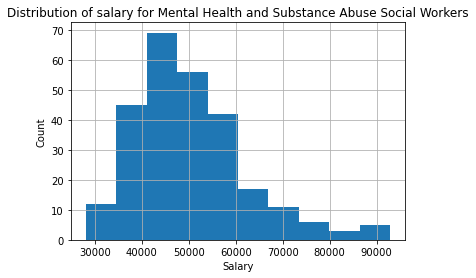

In [144]:
salary_dist('Mental Health and Substance Abuse Social Workers')

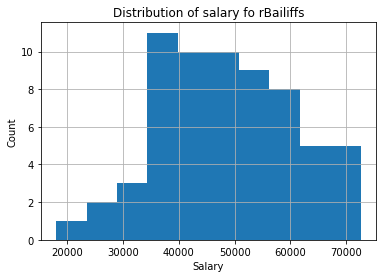

In [142]:
salary_dist('Bailiffs')

#### 2.2.2. Summary statistics

In [41]:
# Salary statistics for each occupation
occupation_stats = df.groupby('occupation')['salary'].describe()
occupation_stats.head()

,count,mean,std,min,25%,50%,75%,max
occupation,,,,,,,,
Accountants and Auditors,13860.0,71805.277778,9863.620539,29210.0,66627.5,71495.0,76517.5,111680.0
Actuaries,2205.0,113659.365079,16774.664509,61750.0,107290.0,115730.0,123980.0,156910.0
Acute Care Nurses,13230.0,72973.783069,15181.970944,27160.0,65150.0,70025.0,76660.0,149200.0
Adapted Physical Education Specialists,3115.0,63093.483146,14022.145306,28170.0,54990.0,64020.0,71430.0,98040.0
Adhesive Bonding Machine Operators and Tenders,1575.0,37033.777778,4603.571001,28230.0,33530.0,37090.0,39530.0,52880.0


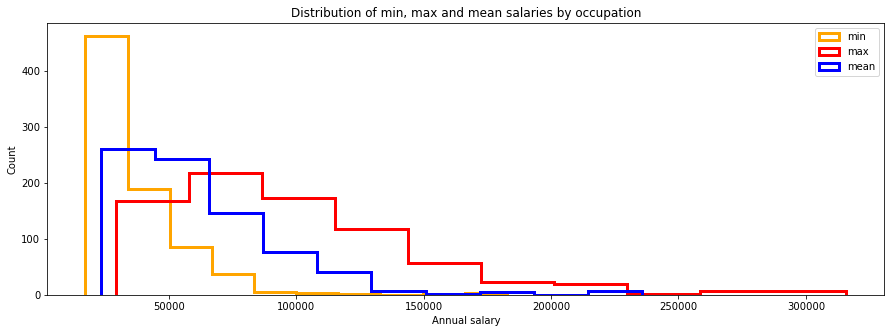

In [68]:
# Distribution of min, max and mean salaries by occupation
fig, ax = plt.subplots(figsize=(15,5))
plt.hist(occupation_stats['min'], histtype='step', linewidth=3, label='min', color='orange')
plt.hist(occupation_stats['max'], histtype='step', linewidth=3, label='max', color='red')
plt.hist(occupation_stats['mean'], histtype='step', linewidth=3, label='mean', color='blue')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of min, max and mean salaries by occupation')
plt.legend();

In [69]:
# Salary statistics for each state
state_stats=df.groupby('state')['salary'].describe()
state_stats.head()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AK,20860.0,72039.530201,31516.526027,24550.0,46557.5,69725.0,90020.0,240630.0
AL,126525.0,55418.735823,31268.225727,17440.0,33020.0,47620.0,67880.0,292110.0
AR,62755.0,53508.499721,29501.426893,19660.0,32930.0,45080.0,65500.0,247020.0
AZ,80605.0,58553.278333,30051.173346,25370.0,36760.0,49900.0,72180.0,279240.0
CA,362670.0,72027.821849,37267.193757,27710.0,42690.0,63030.0,92720.0,302040.0


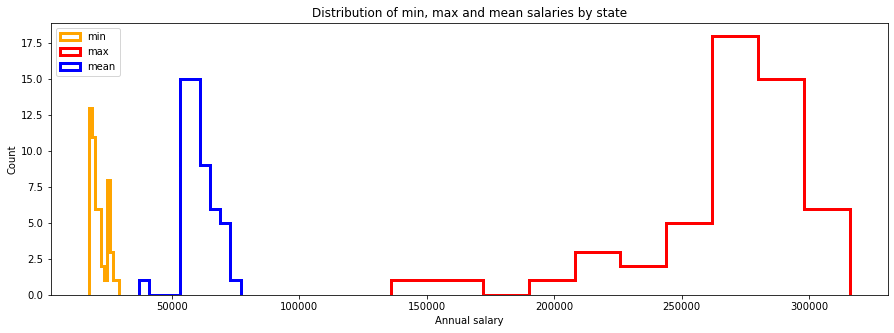

In [70]:
# Distribution of min, max and mean salaries by state
fig, ax = plt.subplots(figsize=(15,5))
plt.hist(state_stats['min'], histtype='step', linewidth=3, label='min', color='orange')
plt.hist(state_stats['max'], histtype='step', linewidth=3, label='max', color='red')
plt.hist(state_stats['mean'], histtype='step', linewidth=3, label='mean', color='blue')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of min, max and mean salaries by state')
plt.legend();

In [62]:
# Average income for across all occupations, by state
income_average_per_state = df.groupby('state')['salary'].mean()
total_mean=income_average_per_state.mean()

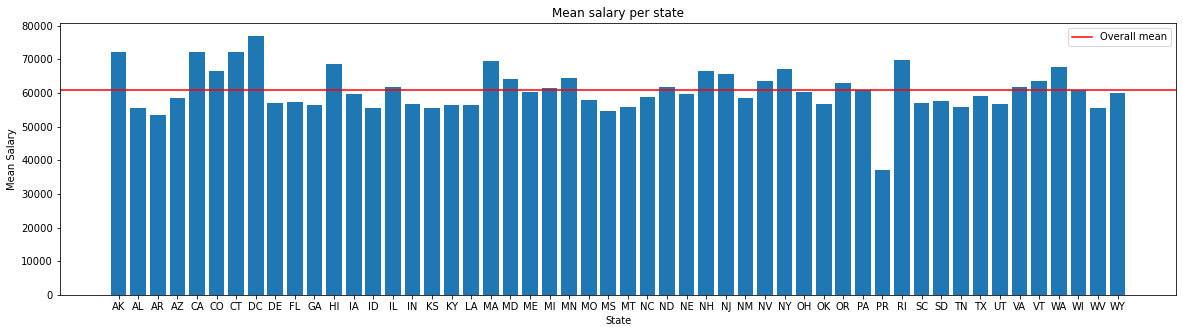

In [67]:
# Bar plot average income across all occupations by state with mean of all income represented with horizontal red line
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(income_average_per_state.index, income_average_per_state)
ax.axhline(y=total_mean, color='red', label='Overall mean')
ax.set_xlabel('State')
ax.set_ylabel('Mean Salary')
plt.title('Mean salary per state')
ax.legend();

In [77]:
# Pivot table so that each skill is a column (variable)
skills = df.pivot_table(values='importance',index=['occupation', 'location', 'salary'],columns='skill').reset_index()
skills.head()

skill,occupation,location,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
0,Accountants and Auditors,Abilene,70550.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
1,Accountants and Auditors,Aguadilla-Isabela,29630.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
2,Accountants and Auditors,Akron,75550.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
3,Accountants and Auditors,Albany,63940.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
4,Accountants and Auditors,Albany,70280.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75


In [74]:
skills.shape

(136400, 38)

In [75]:
df.shape

(4774000, 6)

In [76]:
# Number of rows for skills dataframe should be 35 times smaller than the original df because there are 35 skills
4774000/136400

35.0

In [79]:
# Skill statistics
skills.describe().T

,count,mean,std,min,25%,50%,75%,max
skill,,,,,,,,
salary,136400.0,61028.508211,32704.537013,17300.00,37320.00,52970.00,76200.00,315830.00
Active Learning,136400.0,3.111028,0.488626,1.88,2.88,3.12,3.50,4.12
Active Listening,136400.0,3.626720,0.445123,2.00,3.19,3.75,4.00,5.00
Complex Problem Solving,136400.0,3.196172,0.503277,1.88,2.88,3.12,3.62,4.38
Coordination,136400.0,3.175869,0.391938,2.00,3.00,3.00,3.44,4.25
Critical Thinking,136400.0,3.500288,0.446187,2.25,3.12,3.62,3.88,4.88
Equipment Maintenance,136400.0,1.635661,0.814806,1.00,1.00,1.12,2.19,4.25
Equipment Selection,136400.0,1.643377,0.671367,1.00,1.00,1.50,2.12,3.75
Installation,136400.0,1.239572,0.531144,1.00,1.00,1.00,1.12,4.75


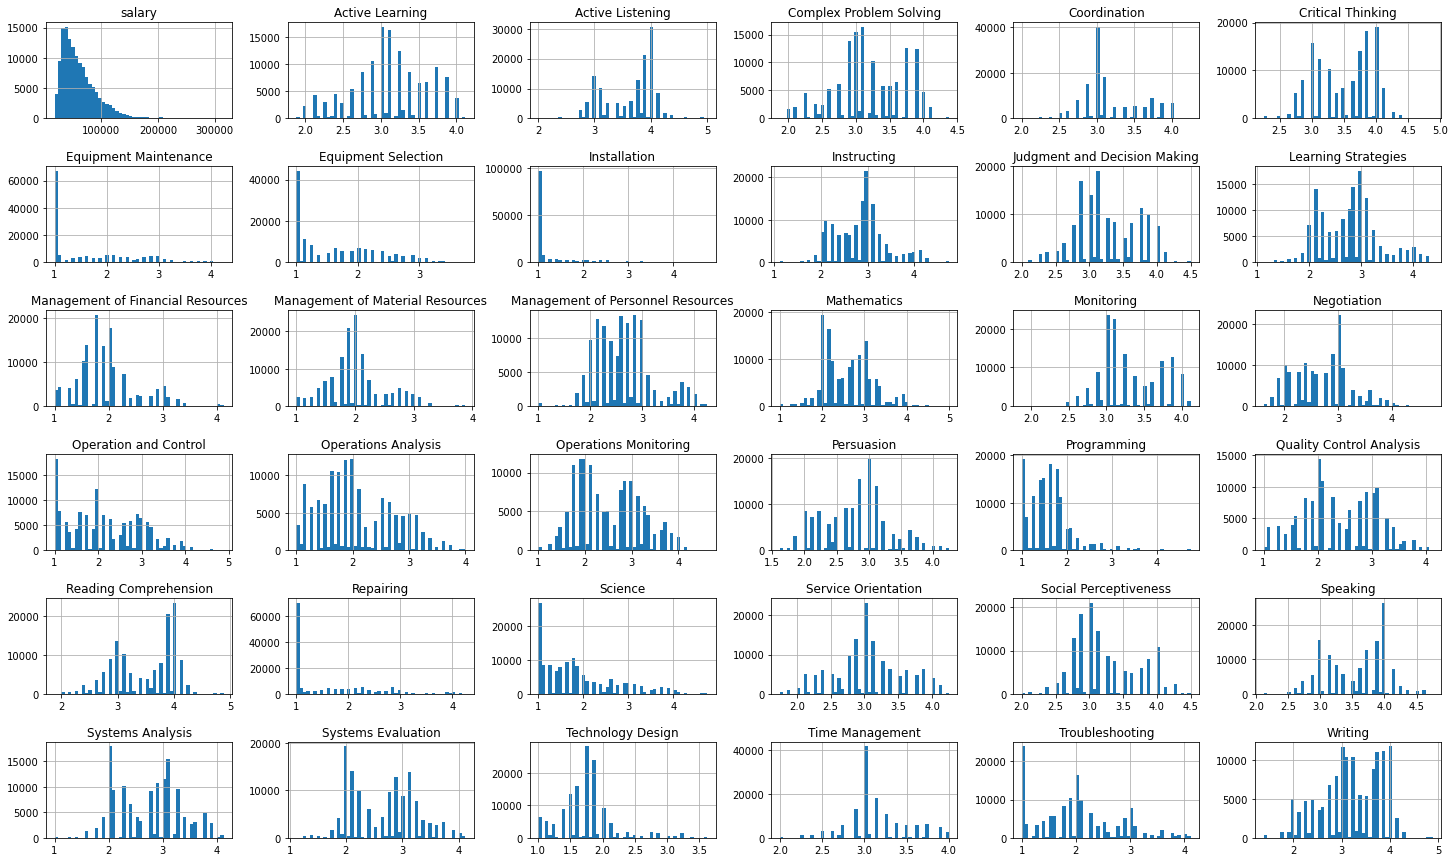

In [80]:
# Histograms of each variable in skills dataframe
skills.hist(figsize=(25, 15), bins=50)
plt.subplots_adjust(hspace=0.5);

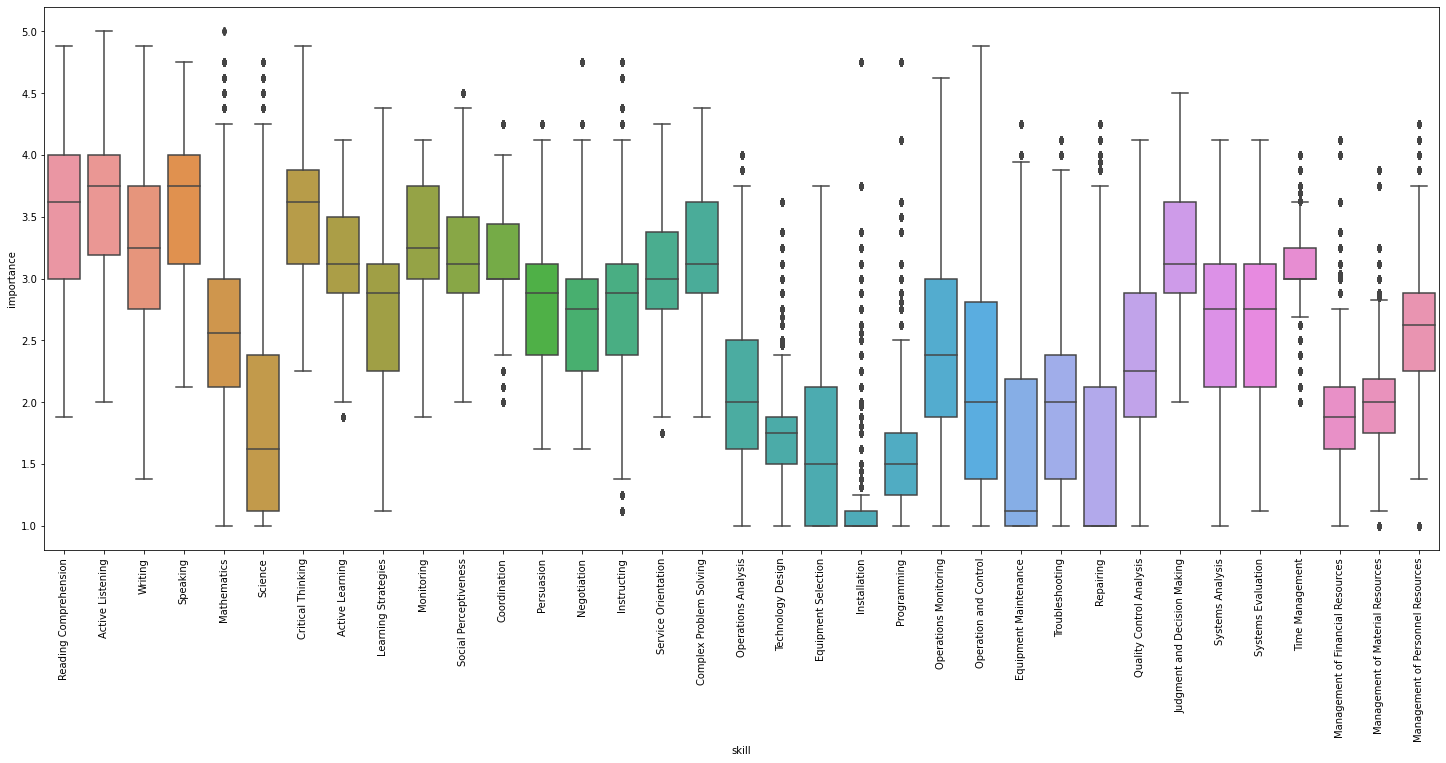

In [81]:
# Box plot of values for each skill
plt.subplots(figsize=(25,10))
sns.boxplot(x='skill', y='importance', data=df)
plt.xticks(rotation=90);

In [82]:
# List of features(skills) to plot vs target feature(salary)
features = [x for x in skills.set_index(['occupation', 'location', 'salary']).columns]

In [88]:
# Function to create scatter plots
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'salary', data=skills.set_index('occupation'), alpha=0.5)
        ax.set(xlabel=col, ylabel='Salary')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

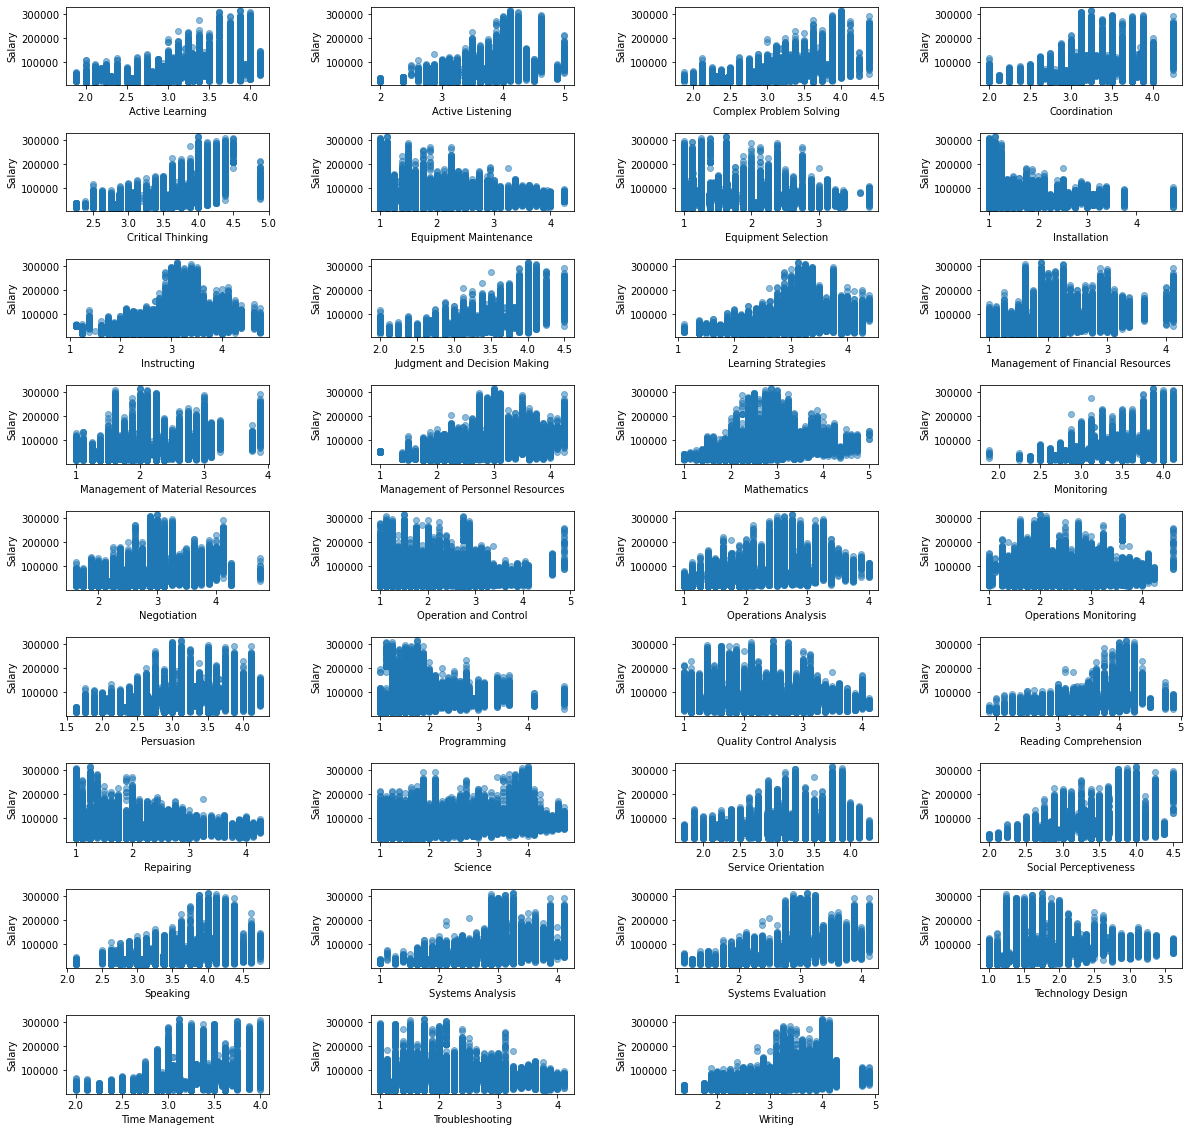

In [90]:
# Scatter plots of each skill vs salary
scatterplots(features, ncol=4, figsize=(20, 20));

In [93]:
# Correlation matrix for skills
corr_matrix = skills.corr()
corr_matrix.head()

skill,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
skill,,,,,,,,,,,,,,,,,,,,,
salary,1.000000,0.628353,0.483368,0.667857,0.394545,0.674526,-0.159069,-0.078925,-0.066269,0.437761,...,0.526607,0.185727,0.346446,0.479958,0.637407,0.638088,0.386274,0.507444,-0.085982,0.569144
Active Learning,0.628353,1.000000,0.774946,0.845577,0.600427,0.855405,-0.312433,-0.224529,-0.131881,0.776462,...,0.561484,0.491319,0.637031,0.757161,0.772608,0.779320,0.421154,0.642923,-0.234332,0.827792
Active Listening,0.483368,0.774946,1.000000,0.714326,0.598240,0.779010,-0.554470,-0.493600,-0.336355,0.657805,...,0.373753,0.655444,0.741240,0.909530,0.630315,0.620914,0.245538,0.604422,-0.495360,0.830851
Complex Problem Solving,0.667857,0.845577,0.714326,1.000000,0.560370,0.881835,-0.216572,-0.129024,-0.045004,0.668243,...,0.599643,0.360208,0.522973,0.696785,0.846801,0.853745,0.548943,0.637208,-0.122282,0.792686
Coordination,0.394545,0.600427,0.598240,0.560370,1.000000,0.591619,-0.326987,-0.264856,-0.216642,0.655907,...,0.206563,0.593862,0.747218,0.646283,0.551159,0.580712,0.178635,0.715109,-0.242328,0.525333


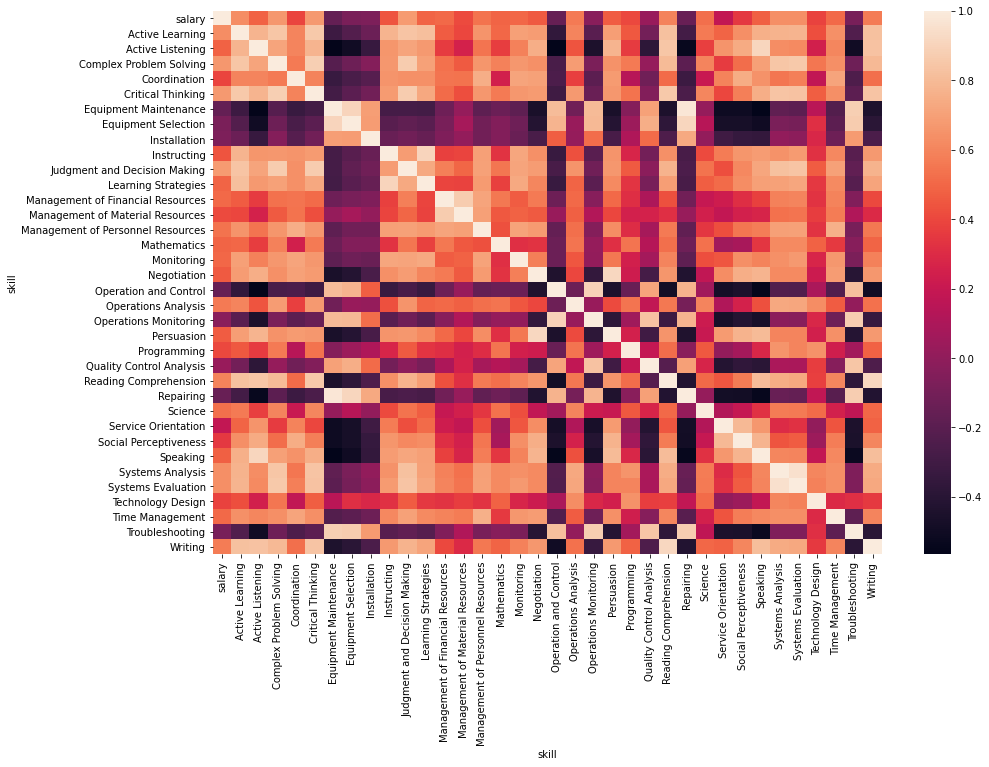

In [94]:
# Look at full heatmap of skills data
fig, ax=plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix);

In [28]:

manual_skills = skills[['Installation', 'Repairing', 'Equipment Maintenance', 'Equipment Selection']]
manual_skills.head()

skill,Installation,Repairing,Equipment Maintenance,Equipment Selection
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


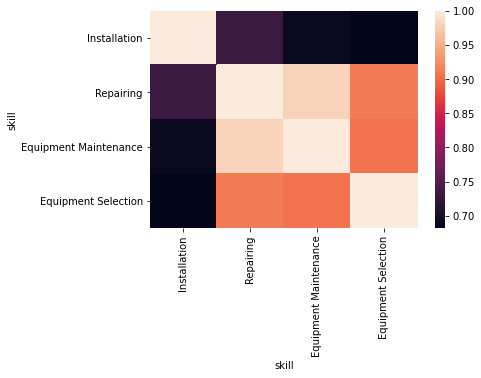

In [29]:
sns.heatmap(manual_skills.corr());

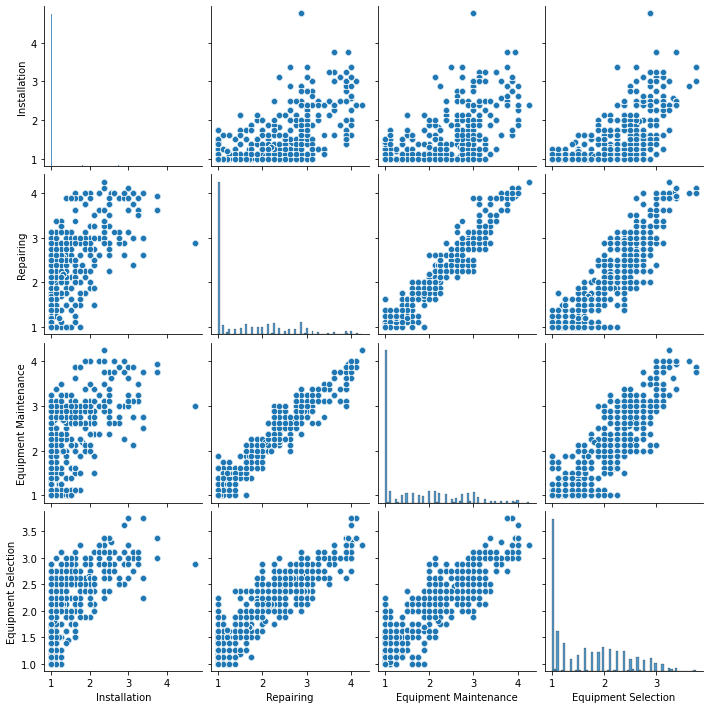

In [30]:
sns.pairplot(manual_skills);

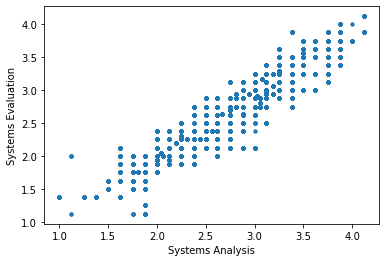

In [31]:
plt.plot(skills['Systems Analysis'], skills['Systems Evaluation'], marker='.', linestyle='none')
plt.xlabel('Systems Analysis')
plt.ylabel('Systems Evaluation');

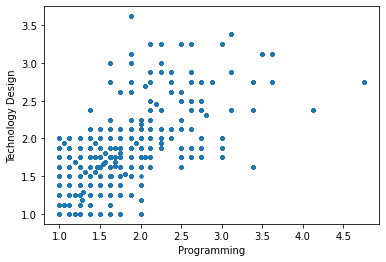

In [32]:
plt.plot(skills['Programming'], skills['Technology Design'], marker='.', linestyle='none')
plt.xlabel('Programming')
plt.ylabel('Technology Design');

In [33]:
learning_skills = skills[['Critical Thinking', 'Complex Problem Solving', 'Active Learning', 'Active Listening', 'Learning Strategies', 'Judgment and Decision Making']]
learning_skills.head()

skill,Critical Thinking,Complex Problem Solving,Active Learning,Active Listening,Learning Strategies,Judgment and Decision Making
0,3.88,3.44,3.31,3.94,2.94,3.5
1,3.88,3.44,3.31,3.94,2.94,3.5
2,3.88,3.44,3.31,3.94,2.94,3.5
3,3.88,3.44,3.31,3.94,2.94,3.5
4,3.88,3.44,3.31,3.94,2.94,3.5


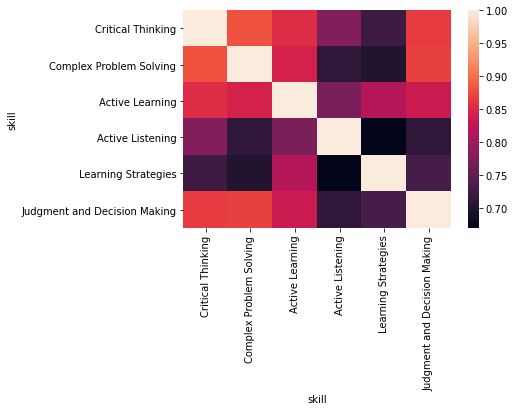

In [34]:
sns.heatmap(learning_skills.corr());

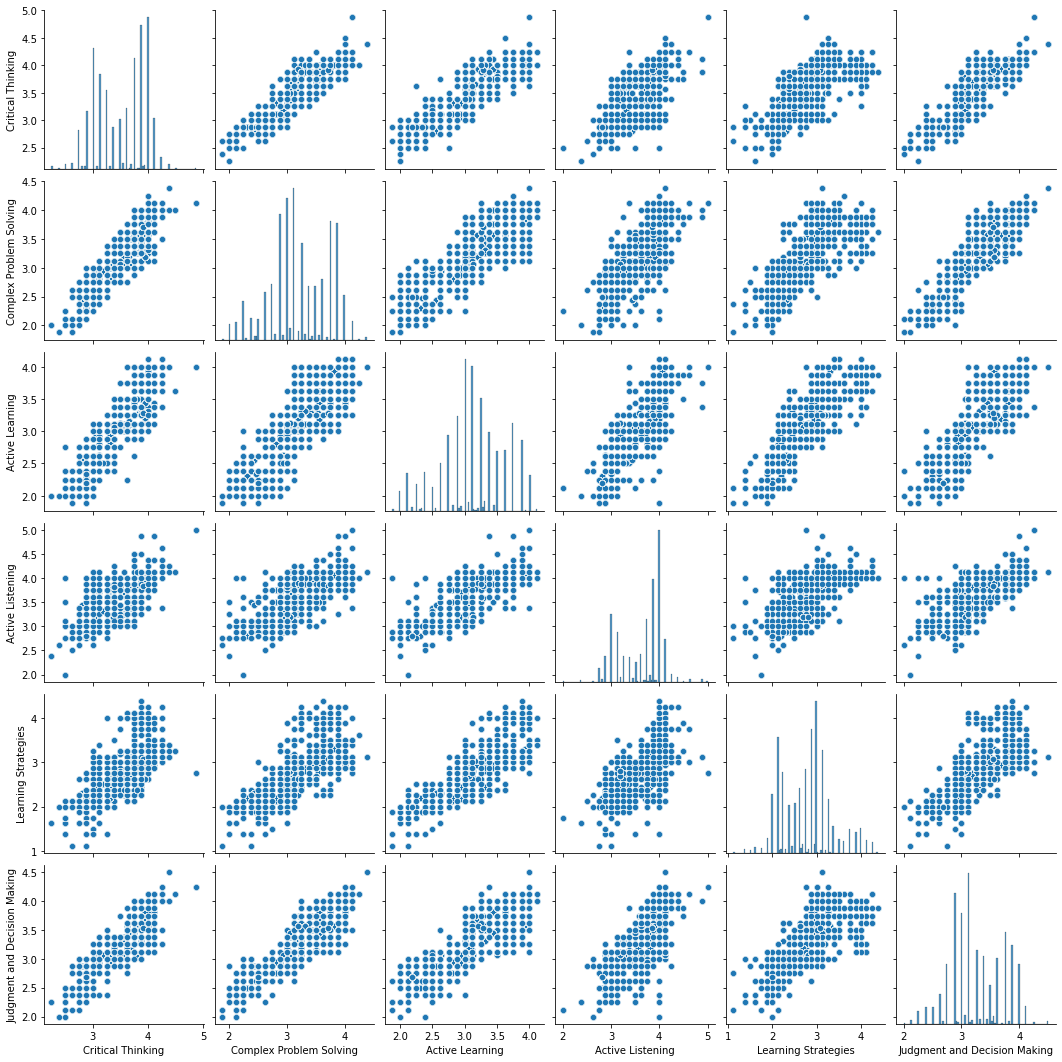

In [35]:
sns.pairplot(learning_skills);

In [36]:
salary_pca=PCA().fit(skills.set_index(['occupation','salary']))

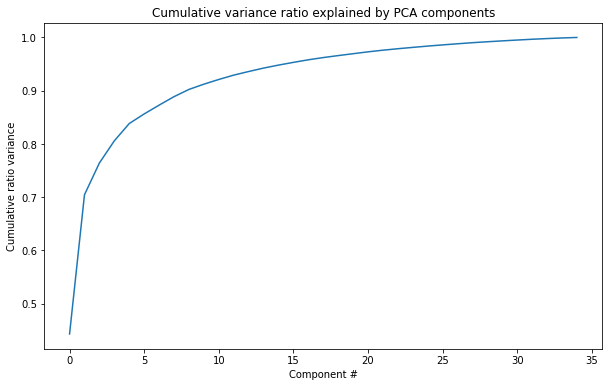

In [37]:
plt.subplots(figsize=(10, 6))
plt.plot(salary_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components');

In [38]:
salary_pca_x = salary_pca.transform(skills.set_index(['occupation','salary']))

In [39]:
salary_pca_x.shape

(129120, 35)